<a href="https://colab.research.google.com/github/smwalter96/Urban_Green_Space_Equity_Health_Factors/blob/main/Urban_Green_Space_Equity_Health_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Equity and Health Effects of Urban Green Space in the United States.

**Abstract**: Urban green spaces (UGS) are areas of vegetation within city centers that have been shown to have many health benefits and be essential to public health within cities. This project will use a normalized difference vegetation index (NDVI) to represent UGS and socioeconomic variables with a random forest regression model to understand how equitably UGS are spread across the United States. Socioeconomic variables and NDVI will also be used to predict health factors in cities such as diabetes, blood pressure, and heart disease.

**Data:** Was collected at the census tract level for 2018.



*Socioeconomic variables* were obtained from the 2018 American Community Survey.

 > pdensity = population density

 > a_dens = density of asian americans

 > b_dens = density of black americans

 > w_dens = density of white americans

 > income = average household income

 > age = average age



*Geographic boudaries* were obtained from https://www2.census.gov/geo/tiger/TIGER2018/TRACT/

*Environmental variables* were obtained from ERA5 satellite data: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY

> temp = average temperature (K)

> precip = total yearly precipitation (m)


*Health factor variables* were obtained from the CDC 500 Cities dataset: https://chronicdata.cdc.gov/500-Cities-Places/500-Cities-Local-Data-for-Better-Health-2019-relea/6vp6-wxuq

> Arthritis: Percentage of population with arthritis

> Binge_Drinking: Percentage of population who binge drinks

> Blood_Pressure: Percentage of population with high blood pressure

> Cancer: Percentage of the population with cancer

> Heart_Disease: Percentage of the population with coronary heart disease

> Pulmonary_Disease: Percentage of the population with chronic pulmonary diease

> Diabetes: Percentage of the population with diabetes

> Sleep: Percentage of the population getting less than 7 hours of sleep

> Stroke: Percentage of the population experiencing strokes

> Obesity: Percentage of the population with obesity

> Smoking: Percentage of the population who smokes cigarettes 


**Install and import packages**

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 5.8MB/s 
     |████████████████████████████████| 14.8MB 376kB/s 
     |████████████████████████████████| 6.5MB 49.3MB/s 


In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 4.5MB/s 


In [ ]:
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import eli5
from eli5.sklearn import PermutationImportance
from scipy.stats import pearsonr

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dat = pd.read_csv('/content/drive/MyDrive/NDVI_US_Urban_PUS.csv')
dat = dat[['GEOID', 'MATCH', 'a_pop', 'age', 'b_pop', 'income', 'mean', 'pdensity', 'w_pop', 'pop']]

Import and plot health data

In [ ]:
health = pd.read_csv('/content/drive/MyDrive/Health_Data_PUS.csv')
health.describe()

,Unnamed: 0,PlaceFIPS,TractFIPS,Arthritis,Binge_Drinking,High_Blood_Pressure,Cancer,Asthma,Coronary_Heart_Disease,Chronic_Pulmonary_Disease,Diabetes,Sleep,Stroke,Obesity,Smoking
count,27210.000000,2.721000e+04,2.721000e+04,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000
mean,13604.500000,2.605539e+06,2.586284e+10,21.430129,18.066953,30.653208,5.648912,9.741352,5.602977,6.309960,10.811062,36.716836,3.211466,30.472922,17.973047
std,7854.994749,1.681206e+06,1.671749e+10,5.995361,4.032559,8.260472,1.803257,1.710538,2.118858,2.545739,4.269441,5.956493,1.449541,8.180685,6.114202
min,0.000000,1.500300e+04,1.073000e+09,2.400000,2.800000,5.300000,0.700000,5.600000,0.300000,1.000000,0.800000,16.100000,0.300000,9.600000,2.000000
25%,6802.250000,6.815540e+05,8.001009e+09,17.300000,15.500000,25.300000,4.500000,8.500000,4.200000,4.500000,7.900000,32.400000,2.300000,24.500000,13.400000
50%,13604.500000,2.622000e+06,2.607700e+10,21.000000,17.800000,29.500000,5.500000,9.400000,5.300000,5.800000,10.000000,36.100000,2.900000,29.500000,17.100000
75%,20406.750000,4.052500e+06,4.010910e+10,25.100000,20.300000,34.900000,6.600000,10.700000,6.700000,7.600000,12.900000,40.600000,3.800000,35.600000,21.700000
max,27209.000000,5.613900e+06,5.602100e+10,58.400000,44.100000,70.300000,22.900000,17.800000,35.800000,23.800000,39.500000,58.700000,19.500000,58.600000,50.300000


In [ ]:
# Calculate the average
arthritis_m = health['Arthritis'].mean()
drinking_m = health['Binge_Drinking'].mean()
bp_m = health['High_Blood_Pressure'].mean()
cancer_m = health['Cancer'].mean()
chd_m = health['Coronary_Heart_Disease'].mean()
cpd_m = health['Chronic_Pulmonary_Disease'].mean()
diabetes_m = health['Diabetes'].mean()
sleep_m = health['Sleep'].mean()
stroke_m = health['Stroke'].mean()
obesity_m = health['Obesity'].mean()
smoking_m = health['Smoking'].mean()





# Calculate the standard deviation
arthritis_s = health['Arthritis'].std()
drinking_s = health['Binge_Drinking'].std()
bp_s = health['High_Blood_Pressure'].std()
cancer_s = health['Cancer'].std()
chd_s = health['Coronary_Heart_Disease'].std()
cpd_s = health['Chronic_Pulmonary_Disease'].std()
diabetes_s = health['Diabetes'].std()
sleep_s = health['Sleep'].std()
stroke_s = health['Stroke'].std()
obesity_s = health['Obesity'].std()
smoking_s = health['Smoking'].std()

# Define labels, positions, bar heights and error bar heights
labels = ['Arthritis', 'Binge Drinking', 'High Blood Pressure', 'Cancer', 'Coronary Heart Disease', 'Chronic Pulmonary Disease', 'Diabetes', 'Sleep Under 7 Hours', 'Stroke', 'Obesity', 'Smoking']
x_pos = np.arange(len(labels))
CTEs = [arthritis_m, drinking_m, bp_m, cancer_m, chd_m, cpd_m, diabetes_m, sleep_m, stroke_m, obesity_m, smoking_m]
error = [arthritis_s, drinking_s, bp_s, cancer_s, chd_s, cpd_s, diabetes_s, sleep_s, stroke_s, obesity_s, smoking_s]

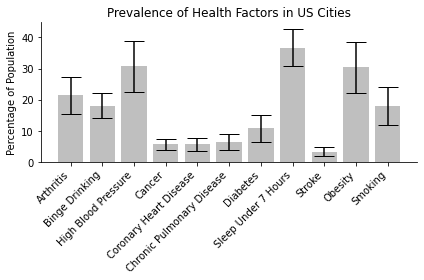

In [ ]:
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       color='grey',
       ecolor='black',
       capsize=10)
ax.set_ylabel('Percentage of Population')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.set_title('Prevalence of Health Factors in US Cities')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

Figure 1: The average percentage of the population in US cities that are affected by different health factors. High blood pressure and sleep under 7 hours are the most common health factors while strokes and cancer are the lowest.

Merge census tracts to health data

In [ ]:
def gettract(cname):
  return cname.split('-')[-1]
health["GEOID"] = health.Place_TractID.astype(str).map(gettract)
health['GEOID1'] = health['GEOID'].astype(int)

In [ ]:
dat = dat.merge(health, left_on = 'GEOID', right_on = 'GEOID1')
dat.head()

,GEOID_x,MATCH,a_pop,age,b_pop,income,mean,pdensity,w_pop,pop,Unnamed: 0,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Arthritis,Binge_Drinking,High_Blood_Pressure,Cancer,Asthma,Coronary_Heart_Disease,Chronic_Pulmonary_Disease,Diabetes,Sleep,Stroke,Obesity,Smoking,GEOID_y,GEOID1
0,36001002500,36Census Tract 251,0,27.1,2441,18971,0.142750,2013.744359,365,3413,16257,NY,Albany,3601000,36001002500,3601000-36001002500,26.3,13.4,38.8,4.2,13.8,7.2,10.0,16.6,48.1,5.2,44.2,31.0,36001002500,36001002500
1,36001001400,36Census Tract 141,365,30.8,771,44790,0.267874,2369.159006,2693,3990,16245,NY,Albany,3601000,36001001400,3601000-36001001400,16.0,23.7,20.4,4.2,9.3,3.5,3.9,6.0,34.8,1.7,24.9,15.1,36001001400,36001001400
2,35001004739,35Census Tract 47.391,159,28.3,87,41859,0.115338,1810.426056,5112,7013,16148,NM,Albuquerque,3502000,35001004739,3502000-35001004739,18.9,16.0,23.5,3.5,10.7,4.1,5.0,9.3,36.8,2.4,32.7,22.7,35001004739,35001004739
3,35001004748,35Census Tract 47.481,140,32.9,133,78965,0.133019,1614.310243,9237,10784,16157,NM,Albuquerque,3502000,35001004748,3502000-35001004748,18.4,19.3,20.1,4.6,9.6,3.1,3.6,5.7,32.1,1.7,25.0,15.8,35001004748,35001004748
4,8001007900,8Census Tract 791,119,30.2,834,41738,0.170150,1929.676683,2832,5684,6792,CO,Aurora,804000,8001007900,0804000-08001007900,18.3,17.0,25.0,3.7,10.5,4.4,5.3,9.8,36.4,2.8,34.7,23.0,08001007900,8001007900


In [ ]:
latlong = pd.read_csv('/content/drive/MyDrive/urban_centers_latlong.csv')
latlong.head()

,Unnamed: 0,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state1,county1,MATCH
0,0,5,119,3304,5119003304,33.04,Census Tract 33.04,G5020,S,5503991,409051,34.787523,-92.245855,POINT (-92.2454501360844 34.78769571930854),5,119,5Census Tract 33.04119
1,1,5,119,3500,5119003500,35.00,Census Tract 35,G5020,S,25337534,157182,34.905743,-92.138294,POINT (-92.13851193747659 34.9038245596053),5,119,5Census Tract 35119
2,2,5,119,3607,5119003607,36.07,Census Tract 36.07,G5020,S,5936932,41426,34.856007,-92.086512,POINT (-92.08886129099896 34.85630675160955),5,119,5Census Tract 36.07119
3,3,5,119,3608,5119003608,36.08,Census Tract 36.08,G5020,S,4885717,0,34.874162,-92.104379,POINT (-92.10437891580091 34.87416161457914),5,119,5Census Tract 36.08119
4,4,5,119,4007,5119004007,40.07,Census Tract 40.07,G5020,S,81229886,6773298,34.674419,-92.215355,POINT (-92.20715834278229 34.66703127520943),5,119,5Census Tract 40.07119


In [ ]:
def gettract(cname):
  return cname.split('(')[-1]
latlong["tot"] = latlong.geometry.astype(str).map(gettract)

def gettract(cname):
  return cname.split(')')[0]
latlong["tot"] = latlong.tot.astype(str).map(gettract)

def gettract(cname):
  return cname.split(' ')[-1]
latlong["lat"] = latlong.tot.astype(str).map(gettract)

def gettract(cname):
  return cname.split(' ')[0]
latlong["long"] = latlong.tot.astype(str).map(gettract)


latlong['long'] = latlong['long'].astype(float)
latlong['lat'] = latlong['lat'].astype(float)
latlong = latlong[['GEOID', 'lat', 'long']]


In [ ]:
latlong

,GEOID,lat,long
0,5119003304,34.787696,-92.245450
1,5119003500,34.903825,-92.138512
2,5119003607,34.856307,-92.088861
3,5119003608,34.874162,-92.104379
4,5119004007,34.667031,-92.207158
...,...,...,...
72533,55043960800,42.708548,-90.633517
72534,55043960100,43.077745,-90.516883
72535,55043960500,42.806803,-90.868076
72536,55043961100,42.631393,-90.559299


In [ ]:
dat['b_dens'] = dat['b_pop'] / dat['pop']
dat['a_dens'] = dat['a_pop'] / dat['pop']
dat['w_dens'] = dat['w_pop'] / dat['pop']
dat['ndvi'] = dat['mean']
dat.head()

,GEOID_x,MATCH,a_pop,age,b_pop,income,mean,pdensity,w_pop,pop,Unnamed: 0,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Arthritis,Binge_Drinking,High_Blood_Pressure,Cancer,Asthma,Coronary_Heart_Disease,Chronic_Pulmonary_Disease,Diabetes,Sleep,Stroke,Obesity,Smoking,GEOID_y,GEOID1,b_dens,a_dens,w_dens,ndvi
0,36001002500,36Census Tract 251,0,27.1,2441,18971,0.142750,2013.744359,365,3413,16257,NY,Albany,3601000,36001002500,3601000-36001002500,26.3,13.4,38.8,4.2,13.8,7.2,10.0,16.6,48.1,5.2,44.2,31.0,36001002500,36001002500,0.715207,0.000000,0.106944,0.142750
1,36001001400,36Census Tract 141,365,30.8,771,44790,0.267874,2369.159006,2693,3990,16245,NY,Albany,3601000,36001001400,3601000-36001001400,16.0,23.7,20.4,4.2,9.3,3.5,3.9,6.0,34.8,1.7,24.9,15.1,36001001400,36001001400,0.193233,0.091479,0.674937,0.267874
2,35001004739,35Census Tract 47.391,159,28.3,87,41859,0.115338,1810.426056,5112,7013,16148,NM,Albuquerque,3502000,35001004739,3502000-35001004739,18.9,16.0,23.5,3.5,10.7,4.1,5.0,9.3,36.8,2.4,32.7,22.7,35001004739,35001004739,0.012406,0.022672,0.728932,0.115338
3,35001004748,35Census Tract 47.481,140,32.9,133,78965,0.133019,1614.310243,9237,10784,16157,NM,Albuquerque,3502000,35001004748,3502000-35001004748,18.4,19.3,20.1,4.6,9.6,3.1,3.6,5.7,32.1,1.7,25.0,15.8,35001004748,35001004748,0.012333,0.012982,0.856547,0.133019
4,8001007900,8Census Tract 791,119,30.2,834,41738,0.170150,1929.676683,2832,5684,6792,CO,Aurora,804000,8001007900,0804000-08001007900,18.3,17.0,25.0,3.7,10.5,4.4,5.3,9.8,36.4,2.8,34.7,23.0,08001007900,8001007900,0.146728,0.020936,0.498241,0.170150


In [ ]:
dat = dat.merge(latlong, left_on = 'GEOID1', right_on = 'GEOID')

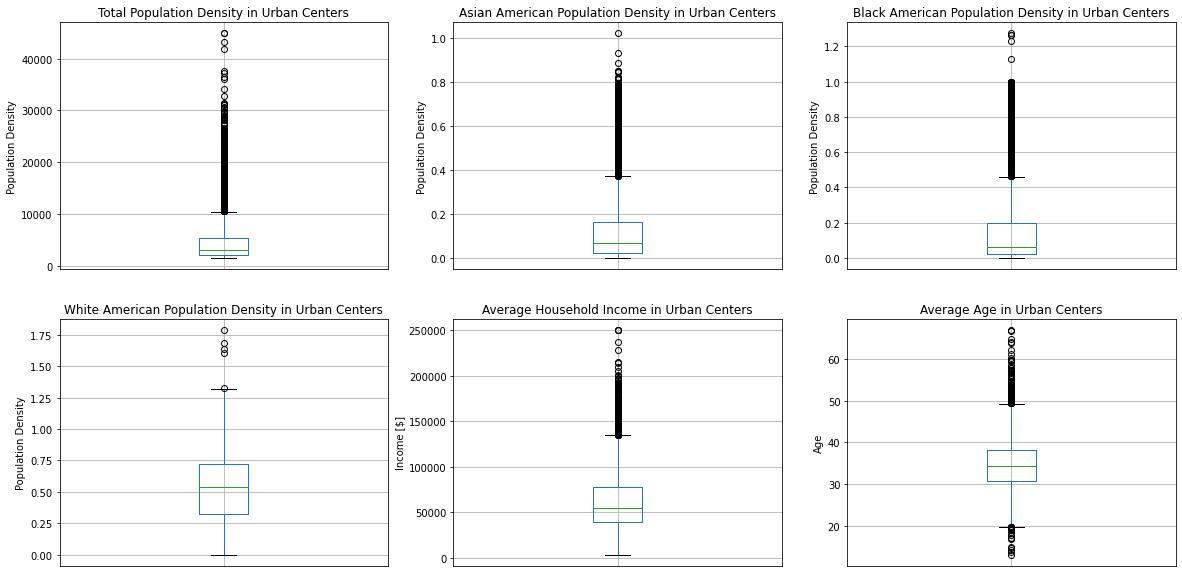

In [ ]:
fig = plt.figure(figsize = [20,10])

plt.subplot(2, 3, 1)

dat.boxplot(column=['pdensity'])
plt.title('Total Population Density in Urban Centers')
plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.ylabel('Population Density')

plt.subplot(2, 3, 2)
dat.boxplot(column=['a_dens'])
plt.title('Asian American Population Density in Urban Centers')
plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.ylabel('Population Density')

plt.subplot(2, 3, 3)
dat.boxplot(column=['b_dens'])
plt.title('Black American Population Density in Urban Centers')
plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.ylabel('Population Density')

plt.subplot(2, 3, 4)
dat.boxplot(column=['w_dens'])
plt.title('White American Population Density in Urban Centers')
plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.ylabel('Population Density')

plt.subplot(2, 3, 5)
dat.boxplot(column=['income'])
plt.title('Average Household Income in Urban Centers')
plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.ylabel('Income [$]')

plt.subplot(2, 3, 6)
dat.boxplot(column=['age'])
plt.title('Average Age in Urban Centers')
plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
plt.ylabel('Age')
plt.show()

Figure 2: Box plots showing distributions for the socioeconomic and NDVI data. Population density, asian american population density, black american population density, and income show several high outliers indicating a skewed distribution. White american population density and age show a more centered distribution.

**NDVI prediction with socioeconmoic variables**

In [ ]:
dat1 = dat[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'lat', 'long', 'ndvi']]
dat1.head()

,age,income,pdensity,b_dens,a_dens,w_dens,lat,long,ndvi
0,27.1,18971,2013.744359,0.715207,0.000000,0.106944,42.641156,-73.755016,0.142750
1,30.8,44790,2369.159006,0.193233,0.091479,0.674937,42.656574,-73.768560,0.267874
2,28.3,41859,1810.426056,0.012406,0.022672,0.728932,35.065418,-106.736079,0.115338
3,32.9,78965,1614.310243,0.012333,0.012982,0.856547,35.198000,-106.737633,0.133019
4,30.2,41738,1929.676683,0.146728,0.020936,0.498241,39.748893,-104.873808,0.170150


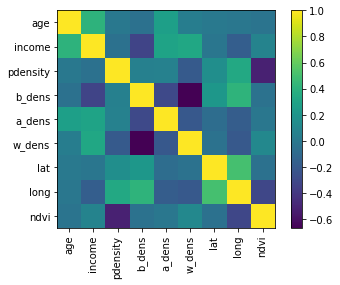

In [ ]:
plt.imshow(dat1.corr())
plt.xticks(range(len(dat1.corr())), dat1.corr().columns, rotation='vertical')
plt.yticks(range(len(dat1.corr())), dat1.corr().columns)
plt.colorbar();

Figure 3: Correlation between different socioeconomic variables, latitude and longitude, and NDVI. This shows that high population densities are associated with low NDVI. High longitude is also associated with low NDVI, showing that western states have lower NDVI.

In [ ]:
x = dat[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'lat', 'long']]
y = dat[['ndvi']]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=1)

In [ ]:

rf = RandomForestRegressor(max_depth=8, random_state=1, n_estimators=500, max_leaf_nodes = 30, min_samples_leaf = 50)
rf.fit(X_train, y_train,)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=30,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
rf.score(X_train, y_train)

0.5554253565165499

In [ ]:
rf.score(X_test, y_test)

0.5120070390217571

In [ ]:
names = list(x.columns.values.tolist())

feature_names = np.array(names)

feature_names


array(['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'lat',
       'long'], dtype='<U8')

[0. 0. 0. 0. 0. 0. 0. 0.]


Text(0.5, 0, 'Random Forest Feature Importance')

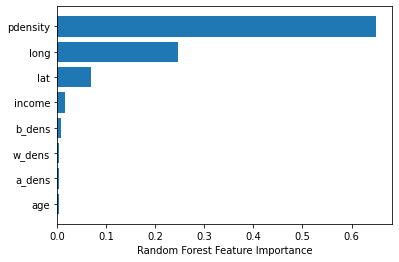

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
std = np.std([sorted_idx for tree in rf.estimators_],
             axis=0)
print(std)
plt.barh(feature_names[sorted_idx], rf.feature_importances_[sorted_idx], yerr=std[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Figure 4: Feature importance in the Random Forest model for each input variable. Population density and longitude have the highest influence on the model in predicting NDVI.

**NDVI prediction with socioeconomic and temperature and precipitation variables**



In [ ]:
precip = pd.read_csv('/content/drive/MyDrive/Precip_US_Urban_PUS.csv')
temp = pd.read_csv('/content/drive/MyDrive/Temp_US_Urban_PUS.csv')
temp['temp'] = temp['mean']
precip['precip'] = precip['mean']

dat = dat.merge(precip, left_on = 'GEOID1', right_on = 'GEOID')
dat = dat.merge(temp, left_on = 'GEOID1', right_on = 'GEOID')
dat.head()

,GEOID_x,MATCH_x,a_pop_x,age_x,b_pop_x,income_x,mean_x,pdensity_x,w_pop_x,pop_x,Unnamed: 0,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Arthritis,Binge_Drinking,High_Blood_Pressure,Cancer,Asthma,Coronary_Heart_Disease,Chronic_Pulmonary_Disease,Diabetes,Sleep,Stroke,Obesity,Smoking,GEOID_y,GEOID1,b_dens,a_dens,w_dens,ndvi,GEOID_x,lat,long,system:index_x,ALAND_x,AWATER_x,...,system:index_y,ALAND_y,AWATER_y,COUNTYFP_y,FUNCSTAT_y,GEOID,ID_y,INTPTLAT_y,INTPTLON_y,MATCH,MATCH1_x_y,MATCH1_y_y,MTFCC_y,NAME_y,NAMELSAD_y,STATEFP_y,TRACTCE_y,a_pop,age,area_y,b_pop,county1_y,county1_x_y,county1_y_y,county_x_y,county_y_y,income,mean,name_x_y,name_y_y,pdensity,pop,state1_y,state1_x_y,state1_y_y,state_x_y,state_y_y,w_pop,.geo_y,temp
0,36001002500,36Census Tract 251,0,27.1,2441,18971,0.142750,2013.744359,365,3413,16257,NY,Albany,3601000,36001002500,3601000-36001002500,26.3,13.4,38.8,4.2,13.8,7.2,10.0,16.6,48.1,5.2,44.2,31.0,36001002500,36001002500,0.715207,0.000000,0.106944,0.142750,36001002500,42.641156,-73.755016,000000000000000011cd,666421,115684,...,000000000000000011cd,666421,115684,1,S,36001002500,7643,42.640709,-73.755972,36Census Tract 251,36Census Tract 251,36Census Tract 251,G5020,25.00,Census Tract 25,36,2500,0,27.1,1.694853,2441,1,1,1,001> tract,001> tract,18971,282.562685,Census Tract 25,Census Tract 25,2013.744359,3413,36,36,36,36> county,36> county,365,"{""type"":""Polygon"",""coordinates"":[[[-73.7632340...",282.562685
1,36001001400,36Census Tract 141,365,30.8,771,44790,0.267874,2369.159006,2693,3990,16245,NY,Albany,3601000,36001001400,3601000-36001001400,16.0,23.7,20.4,4.2,9.3,3.5,3.9,6.0,34.8,1.7,24.9,15.1,36001001400,36001001400,0.193233,0.091479,0.674937,0.267874,36001001400,42.656574,-73.768560,000000000000000011dd,751968,25632,...,000000000000000011dd,751968,25632,1,S,36001001400,7659,42.655972,-73.768850,36Census Tract 141,36Census Tract 141,36Census Tract 141,G5020,14.00,Census Tract 14,36,1400,365,30.8,1.684142,771,1,1,1,001> tract,001> tract,44790,282.525208,Census Tract 14,Census Tract 14,2369.159006,3990,36,36,36,36> county,36> county,2693,"{""type"":""Polygon"",""coordinates"":[[[-73.7772489...",282.525208
2,35001004739,35Census Tract 47.391,159,28.3,87,41859,0.115338,1810.426056,5112,7013,16148,NM,Albuquerque,3502000,35001004739,3502000-35001004739,18.9,16.0,23.5,3.5,10.7,4.1,5.0,9.3,36.8,2.4,32.7,22.7,35001004739,35001004739,0.012406,0.022672,0.728932,0.115338,35001004739,35.065418,-106.736079,000000000000000017fd,1996107,1508,...,000000000000000017fd,1996107,1508,1,S,35001004739,9227,35.065562,-106.735847,35Census Tract 47.391,35Census Tract 47.391,35Census Tract 47.391,G5020,47.39,Census Tract 47.39,35,4739,159,28.3,3.873674,87,1,1,1,001> tract,001> tract,41859,287.431854,Census Tract 47.39,Census Tract 47.39,1810.426056,7013,35,35,35,35> county,35> county,5112,"{""type"":""Polygon"",""coordinates"":[[[-106.742710...",287.431854
3,35001004748,35Census Tract 47.481,140,32.9,133,78965,0.133019,1614.310243,9237,10784,16157,NM,Albuquerque,3502000,35001004748,3502000-35001004748,18.4,19.3,20.1,4.6,9.6,3.1,3.6,5.7,32.1,1.7,25.0,15.8,35001004748,35001004748,0.012333,0.012982,0.856547,0.133019,35001004748,35.198000,-106.737633,000000000000000017ff,3425697,29937,...,000000000000000017ff,3425697,29937,1,S,35001004748,9229,35.196857,-106.737843,35Census Tract 47.481,35Census Tract 47.481,35Census Tract 47.481,G5020,47.48,Census Tract 47.48,35,4748,140,32.9,6.680252,133,1,1,1,001> tract,001> tract,78965,287.425709,Census Tract 47.48,Census Tract 47.48,1614.310243,10784,35,35,35,35> county,35> county,9237,"{""type"":""Polygon"",""coordinates"":[[[-106.752349...",287.425709
4,8001007900,8Census Tract 791,119,30.2,834,41738,0.170150,1929.676683,2832,5684,6792,CO,Aurora,804000,8001007900,0804000-08001007900,18.3,17.0,25.0,3.7,10.5,4.4,5.3,9.8,36.4,2.8,34.7,23.0,08001007900,8001007900,0.146728,0.020936,0.498241,0.170150,8001007900,39.748893,-104.873808,000000000000000000a7,1637878,338,...,000000000000000000a7,1637878,

In [ ]:

x = dat[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'lat', 'long', 'temp', 'precip']]
y = dat[['ndvi']]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

In [ ]:
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=500)
rf.fit(X_train, y_train,)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
rf.score(X_train, y_train)

0.6416461019943402

In [ ]:
rf.score(X_test, y_test)

0.5777551528354438

In [ ]:
names = list(x.columns.values.tolist())

feature_names = np.array(names)

feature_names


array(['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'lat',
       'long', 'temp', 'precip'], dtype='<U8')

Text(0.5, 0, 'Random Forest Feature Importance')

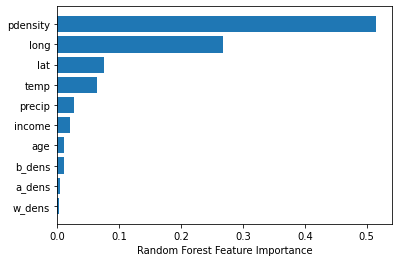

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Figure 5: Importance on the prediction of NDVI for each input variable, with the inclusion of temperature and precipitation. Precipitaion and temperature have higher influence than the socioeconomic variables, but lower influence than population density and location.

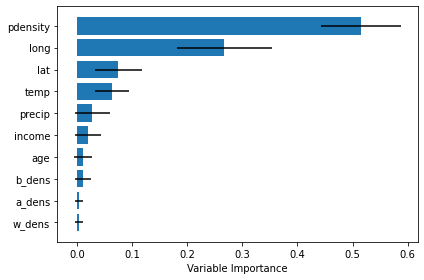

In [ ]:
imp_df = eli5.explain_weights_df(rf)
label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(X_test.columns))], 'feature_name': X_test.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)
 

## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Variable Importance")
plt.tight_layout()

# Show graphic
plt.show()

Figure 6: Variable importance for the model predicting NDVI with socioeconomic, location, and environmental variables with permutation error bars. The error bars show that any variable below temperature has negligible importance in the model.

**Health factor predictions with socioeconomic and ndvi variables**

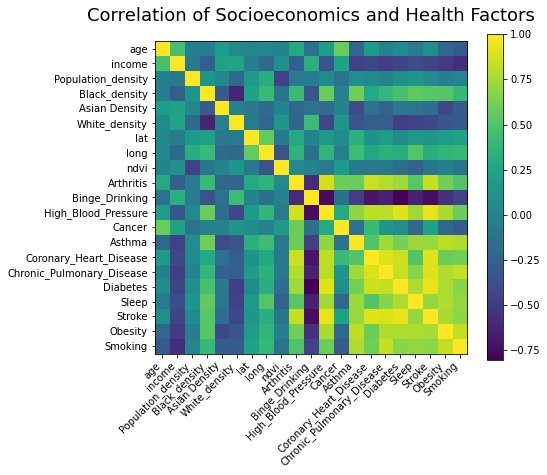

In [ ]:
dat2 = dat[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'lat', 
            'long', 'ndvi','Arthritis', 'Binge_Drinking', 'High_Blood_Pressure', 
            'Cancer', 'Asthma', 'Coronary_Heart_Disease', 
            'Chronic_Pulmonary_Disease', 'Diabetes', 'Sleep', 'Stroke', 'Obesity', 'Smoking']]
dati = dat2
dati = dati.rename(columns={'w_dens': 'White_density', 'b_dens': 'Black_density', 'a_dens': 'Asian Density', 'pdensity': 'Population_density'})

fig = plt.figure(figsize = [7,6])
plt.imshow(dati.corr())
plt.xticks(range(len(dati.corr())), dati.corr().columns, rotation=45, ha="right")

plt.yticks(range(len(dati.corr())), dati.corr().columns)
plt.title("Correlation of Socioeconomics and Health Factors", fontsize = 18, pad=20)
plt.colorbar();

Figure 7: Correlation plot between socioeconomic variables, NDVI, and different health factors. One noteable thing from this plot is how income negatively correlates to all health factors except cancer and binge drinking. Binge drinking also negatively correlates with all of the other health factors.

In [ ]:
ls = ['Arthritis', 'Binge_Drinking', 'High_Blood_Pressure', 'Cancer', 'Asthma', 'Coronary_Heart_Disease', 'Chronic_Pulmonary_Disease', 'Diabetes', 'Sleep', 'Stroke', 'Obesity', 'Smoking']

for factor in ls:
  x = dat[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'ndvi']]
  y = dat[[factor]]
  print(factor)
  
  X_train, X_test, y_train, y_test = train_test_split(
      x, y, test_size=0.3, random_state=42)
  rf = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=500)
  rf.fit(X_train, y_train,)
  print('')
  print('Training R2:', rf.score(X_train, y_train))
  print('Testing R2:', rf.score(X_test, y_test))
  names = list(x.columns.values.tolist())
  feature_names = np.array(names)
  sorted_idx = rf.feature_importances_.argsort()
  sorted_idx = sorted_idx[::-1]

  i = 0
  print('')
  print('Variable Importances (High to Low)')
  for imp in feature_names[sorted_idx]:
    w = rf.feature_importances_[sorted_idx]
    print(imp, ':', w[i])
    i +=1
  print('_________________________________________')
  print('')

Arthritis

Training R2: 0.7196047354153938
Testing R2: 0.6370370190960107

Variable Importances (High to Low)
age : 0.28769977068585645
b_dens : 0.20617133352911327
income : 0.19975467672065858
w_dens : 0.13804055933243725
ndvi : 0.07049026729547075
a_dens : 0.057981945813077335
pdensity : 0.03986144662338633
_________________________________________

Binge_Drinking

Training R2: 0.7101522519752201
Testing R2: 0.6295641932528587

Variable Importances (High to Low)
w_dens : 0.4042333480641926
income : 0.22857097087392653
age : 0.1360990252974526
ndvi : 0.10238866611547018
a_dens : 0.07024335559397321
b_dens : 0.02948509263607801
pdensity : 0.02897954141890684
_________________________________________

High_Blood_Pressure

Training R2: 0.8280996862436489
Testing R2: 0.7711355038939739

Variable Importances (High to Low)
b_dens : 0.36889844031501173
income : 0.1756636933937148
age : 0.16765540862888348
w_dens : 0.16013665150775244
ndvi : 0.06619235279210915
a_dens : 0.039263946354130004
p

Table 1: R2 and variable importance for each heralth factor random forest regression. The models have a range of testing R2 from .6 to .7. By adjusting the model paramaters, overfitting was minimized. The variable importance varies a lot for each health factor. Income is most commonly the variable with the highest importance. For most of these models NDVI has a low importance, with the exception of cancer where it has an importance of .22. 

**Health factor predictions with socioeconomic and ndvi variables by 4 income levels**

To remove the impact of income on the health factors, the dataset is broken down into four income levels where income is <= 25%, 26-50%, 51-75%, and >= 75%, and each model is run again.

In [ ]:
# Income Level 1
dat3 = dat2[dat2.income <= dat2.income.quantile(.25)]
l1 = dat3
# Income Level 2
dat4 = dat2[dat2.income > dat2.income.quantile(.25)]
dat4 = dat4[dat4.income < dat2.income.quantile(.51)]
l2 = dat4
# Income Level 3
dat5 = dat2[dat2.income > dat2.income.quantile(.50)]
dat5 = dat5[dat5.income < dat2.income.quantile(.76)]
l3 = dat5
# Income Level 4
dat6 = dat2[dat2.income > dat2.income.quantile(.76)]
l4 = dat6

In [ ]:
print('Income Level <= 25%')
print('')
print('Income max:', l1['income'].max())
print('Income min:',l1['income'].min())
print('Income mean:',l1['income'].mean())
print('')
print('NDVI max:', l1['ndvi'].max())
print('NDVI min:',l1['ndvi'].min())
print('NDVI mean:',l1['ndvi'].mean())
print('_______________________________')
print('Income Level 26-50%')
print('')
print('Income max:', l2['income'].max())
print('Income min:',l2['income'].min())
print('Income mean:',l2['income'].mean())
print('')
print('NDVI max:', l2['ndvi'].max())
print('NDVI min:',l2['ndvi'].min())
print('NDVI mean:',l2['ndvi'].mean())
print('_______________________________')
print('Income Level 51-75%')
print('')
print('Income max:', l3['income'].max())
print('Income min:',l3['income'].min())
print('Income mean:',l3['income'].mean())
print('')
print('NDVI max:', l3['ndvi'].max())
print('NDVI min:',l3['ndvi'].min())
print('NDVI mean:',l3['ndvi'].mean())
print('_______________________________')
print('Income Level >= 76%')
print('')
print('Income max:', l4['income'].max())
print('Income min:',l4['income'].min())
print('Income mean:',l4['income'].mean())
print('')
print('NDVI max:', l4['ndvi'].max())
print('NDVI min:',l4['ndvi'].min())
print('NDVI mean:',l4['ndvi'].mean())




Income Level <= 25%

Income max: 37459
Income min: 3558
Income mean: 29020.49246231156

NDVI max: 0.3806507762924372
NDVI min: -0.09370166959912472
NDVI mean: 0.13773467718548693
_______________________________
Income Level 26-50%

Income max: 53721
Income min: 37461
Income mean: 45385.97026932494

NDVI max: 0.3592503003749789
NDVI min: -0.0650473759874976
NDVI mean: 0.14707745396799762
_______________________________
Income Level 51-75%

Income max: 77885
Income min: 53397
Income mean: 64221.70872436566

NDVI max: 0.4207791132073152
NDVI min: -0.046056211499579836
NDVI mean: 0.15734073674348997
_______________________________
Income Level >= 76%

Income max: 250001
Income min: 77892
Income mean: 106819.68423033497

NDVI max: 0.3450159070107113
NDVI min: -0.12709237731782785
NDVI mean: 0.16161902379576476


Table 2: Shows the maximum, minimum, and average income and NDVI within each income level. As income level increases so does average NDVI.

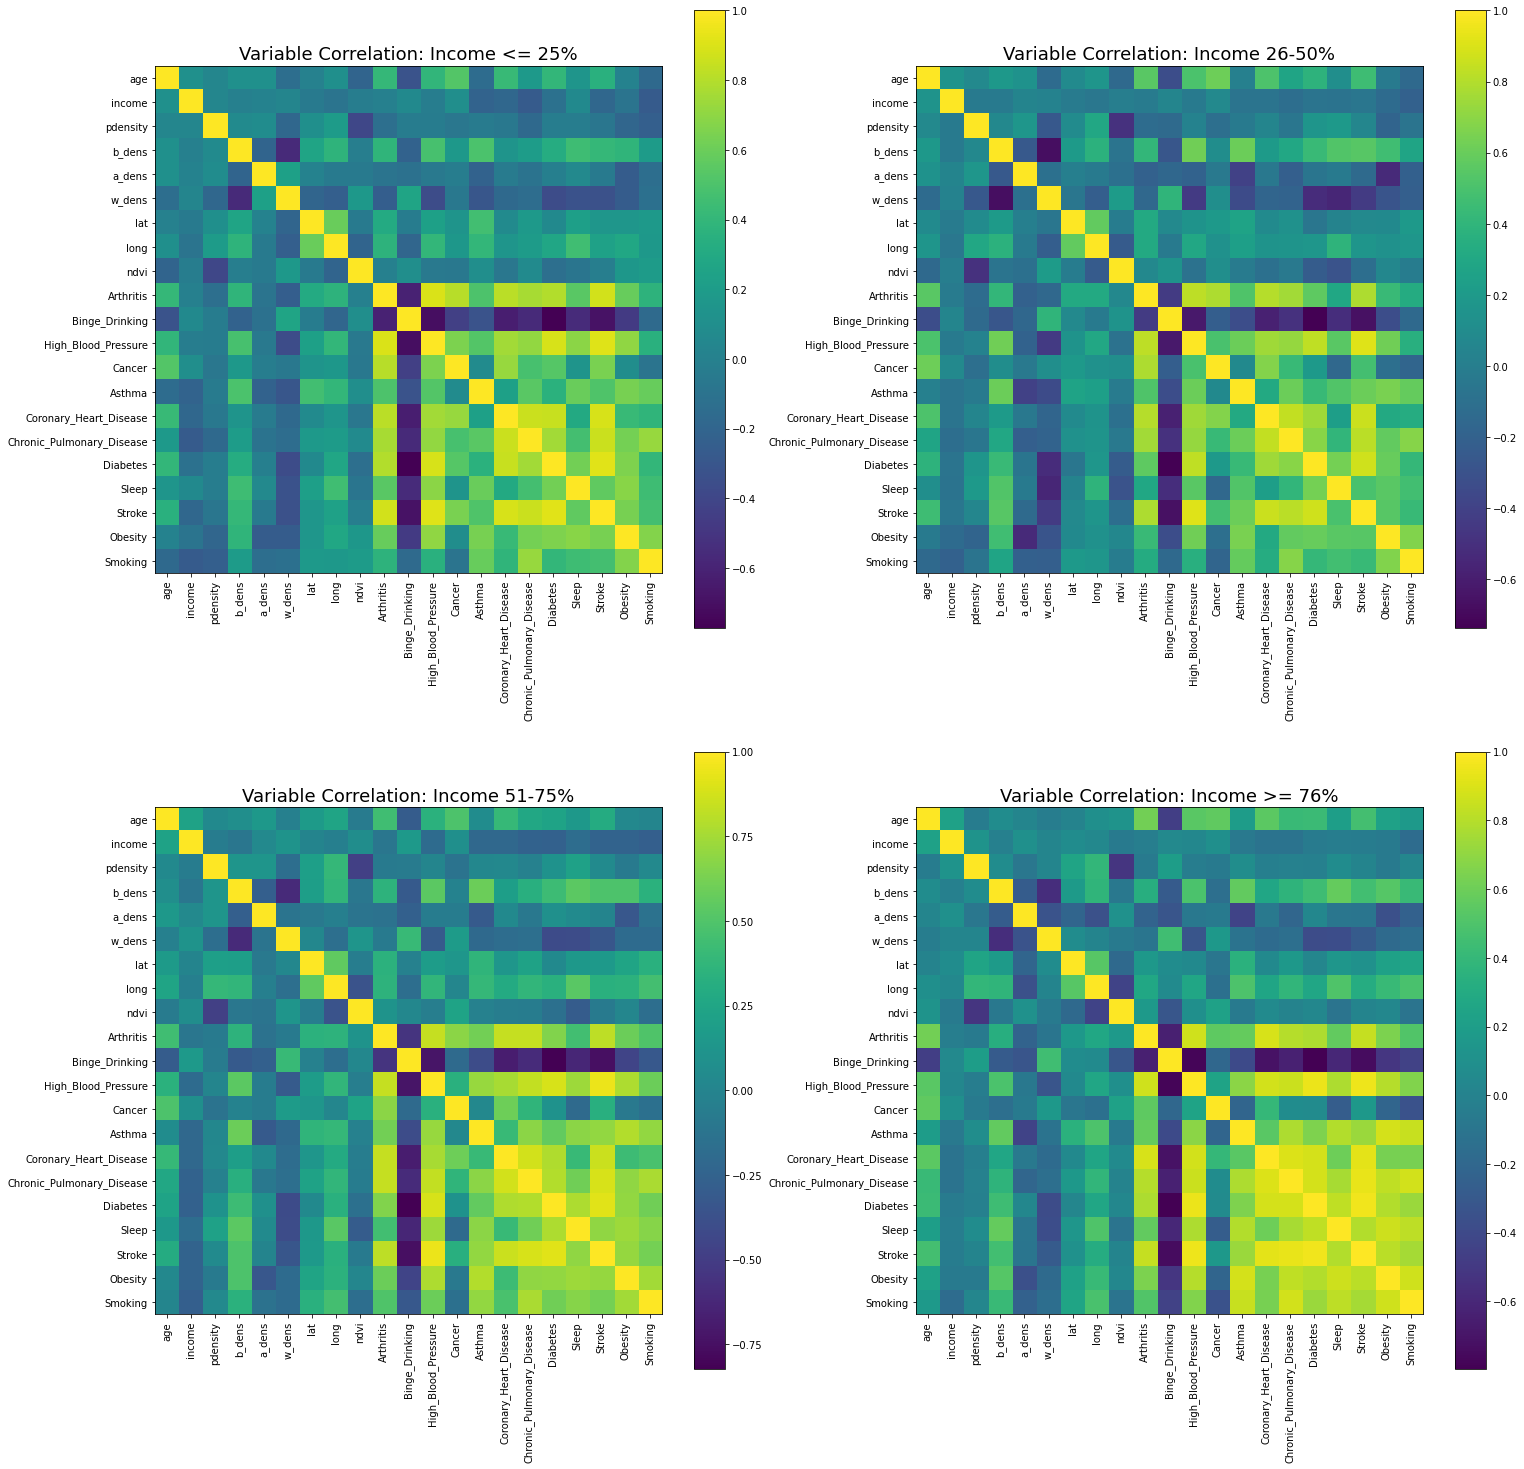

In [ ]:
fig = plt.figure(figsize = [25,25])

plt.subplot(2, 2, 1)
plt.imshow(l1.corr())
plt.xticks(range(len(l1.corr())), l1.corr().columns, rotation='vertical')
plt.yticks(range(len(l1.corr())), l1.corr().columns)
plt.title('Variable Correlation: Income <= 25%', fontsize=18)
plt.colorbar();

plt.subplot(2, 2, 2)
plt.imshow(l2.corr())
plt.xticks(range(len(l2.corr())), l2.corr().columns, rotation='vertical')
plt.yticks(range(len(l2.corr())), l2.corr().columns)
plt.title('Variable Correlation: Income 26-50%', fontsize=18)
plt.colorbar();

plt.subplot(2, 2, 3)
plt.imshow(l3.corr())
plt.xticks(range(len(l3.corr())), l3.corr().columns, rotation='vertical')
plt.yticks(range(len(l3.corr())), l3.corr().columns)
plt.title('Variable Correlation: Income 51-75%', fontsize=18)
plt.colorbar();

plt.subplot(2, 2, 4)
plt.imshow(l4.corr())
plt.xticks(range(len(l4.corr())), l4.corr().columns, rotation='vertical')
plt.yticks(range(len(l4.corr())), l4.corr().columns)
plt.title('Variable Correlation: Income >= 76%', fontsize=18)
plt.colorbar();


plt.show()

Figure 8: Correlation plots between socioeconomic variables, NDVI, and health factors for each of the four income levels. The correlation of income to health factors is now much less compared to the entire dataset. Health factors also become less correlated with eachother as income level becomes lower.

In [ ]:
ls = ['Arthritis', 'Binge_Drinking', 'High_Blood_Pressure', 'Cancer', 'Asthma', 'Coronary_Heart_Disease', 'Chronic_Pulmonary_Disease', 'Diabetes', 'Sleep', 'Stroke', 'Obesity', 'Smoking']
ndvi_imp = pd.DataFrame([])
t_r = pd.DataFrame([])
print('Income <= 25%')
print('_________________________________________')
for factor in ls:
  x = l1[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'ndvi']]
  y = l1[[factor]]
  print(factor)
  
  X_train, X_test, y_train, y_test = train_test_split(
      x, y, test_size=0.3, random_state=42)
  rf = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=500)
  rf.fit(X_train, y_train,)
  print('')
  print('Training R2:', rf.score(X_train, y_train))
  print('Testing R2:', rf.score(X_test, y_test))
  t_r = t_r.append(pd.DataFrame({'Factor': factor, 'Income <= 25%': rf.score(X_test, y_test)}, index=[0]), ignore_index=True)
  names = list(x.columns.values.tolist())
  feature_names = np.array(names)
  sorted_idx = rf.feature_importances_.argsort()
  sorted_idx = sorted_idx[::-1]

  i = 0
  print('')
  print('Variable Importances (High to Low)')
  for imp in feature_names[sorted_idx]:
    w = rf.feature_importances_[sorted_idx]
    print(imp, ':', w[i])
    
    if imp == 'ndvi':
      ndvi_imp = ndvi_imp.append(pd.DataFrame({'Factor': factor, 'Income <= 25%': w[i]}, index=[0]), ignore_index=True)
    i +=1
  print('_________________________________________')
  print('')

Income <= 25%
_________________________________________
Arthritis

Training R2: 0.8158532464268864
Testing R2: 0.7074951168022544

Variable Importances (High to Low)
age : 0.3469527844309707
w_dens : 0.15735905748099777
ndvi : 0.13555598093169952
b_dens : 0.11689797923917435
income : 0.09903065244333098
a_dens : 0.0909348408245833
pdensity : 0.05326870464924348
_________________________________________

Binge_Drinking

Training R2: 0.7298753102626587
Testing R2: 0.558991042457675

Variable Importances (High to Low)
age : 0.27699211576339927
a_dens : 0.18570798090101154
w_dens : 0.1824920826345949
income : 0.16020910873991961
ndvi : 0.07431994598885762
b_dens : 0.06491764991548522
pdensity : 0.05536111605673185
_________________________________________

High_Blood_Pressure

Training R2: 0.8655680216945169
Testing R2: 0.7989704511108363

Variable Importances (High to Low)
w_dens : 0.31872846748385936
age : 0.2995602958184003
b_dens : 0.14363641644782707
income : 0.09497721564719509
a_den

Table 3: R2 and variable importance for each health factor where income is <= 25% of the data in the original dataset. R2 are similar to the model with the entire dataset, ranging from .55 to .8.

In [ ]:
ls = ['Arthritis', 'Binge_Drinking', 'High_Blood_Pressure', 'Cancer', 'Asthma', 'Coronary_Heart_Disease', 'Chronic_Pulmonary_Disease', 'Diabetes', 'Sleep', 'Stroke', 'Obesity', 'Smoking']
print('Income 26-50%')
print('_________________________________________')
for factor in ls:
  x = l2[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'ndvi']]
  y = l2[[factor]]
  print(factor)
  
  X_train, X_test, y_train, y_test = train_test_split(
      x, y, test_size=0.3, random_state=42)
  rf = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=500)
  rf.fit(X_train, y_train,)
  print('')
  print('Training R2:', rf.score(X_train, y_train))
  print('Testing R2:', rf.score(X_test, y_test))
  names = list(x.columns.values.tolist())
  feature_names = np.array(names)
  sorted_idx = rf.feature_importances_.argsort()
  sorted_idx = sorted_idx[::-1]
  t_r = t_r.append(pd.DataFrame({'Factor': factor, 'Income 26-50%': rf.score(X_test, y_test)}, index=[0]), ignore_index=True)
  i = 0
  print('')
  print('Variable Importances (High to Low)')
  for imp in feature_names[sorted_idx]:
    w = rf.feature_importances_[sorted_idx]
    print(imp, ':', w[i])
    
    if imp == 'ndvi':
      ndvi_imp = ndvi_imp.append(pd.DataFrame({'Factor': factor,'Income 26-50%': w[i]}, index=[0]), ignore_index=True)
    i +=1
  print('_________________________________________')
  print('')

Income 26-50%
_________________________________________
Arthritis

Training R2: 0.78455274933671
Testing R2: 0.6221837103619408

Variable Importances (High to Low)
age : 0.4496078364491196
b_dens : 0.15965832061881235
a_dens : 0.11198182336519492
pdensity : 0.08508690217265515
ndvi : 0.0810553649596568
w_dens : 0.06949741411432864
income : 0.04311233832023268
_________________________________________

Binge_Drinking

Training R2: 0.6978052547038409
Testing R2: 0.44669542277141805

Variable Importances (High to Low)
w_dens : 0.35172996455444605
age : 0.20908383553114435
a_dens : 0.10780510587563066
income : 0.10522836177715639
b_dens : 0.08147288337186702
ndvi : 0.07946314522019314
pdensity : 0.06521670366956239
_________________________________________

High_Blood_Pressure

Training R2: 0.8378248899908184
Testing R2: 0.7426027035443397

Variable Importances (High to Low)
b_dens : 0.4865504093912155
age : 0.22887456415461455
income : 0.0697489354218098
w_dens : 0.06869823977810527
a_den

Table 4: R2 and variable importance for each health factor where income is 26-50% of the data in the original dataset. R2 are smaller in this model compared to the model with the entire dataset, ranging from .4 to .74.

In [ ]:
ls = ['Arthritis', 'Binge_Drinking', 'High_Blood_Pressure', 'Cancer', 'Asthma', 'Coronary_Heart_Disease', 'Chronic_Pulmonary_Disease', 'Diabetes', 'Sleep', 'Stroke', 'Obesity', 'Smoking']
print('Income 51-75%')
print('_________________________________________')
for factor in ls:
  x = l3[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'ndvi']]
  y = l3[[factor]]
  print(factor)
  
  X_train, X_test, y_train, y_test = train_test_split(
      x, y, test_size=0.3, random_state=42)
  rf = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=500)
  rf.fit(X_train, y_train,)
  print('')
  print('Training R2:', rf.score(X_train, y_train))
  print('Testing R2:', rf.score(X_test, y_test))
  names = list(x.columns.values.tolist())
  feature_names = np.array(names)
  sorted_idx = rf.feature_importances_.argsort()
  sorted_idx = sorted_idx[::-1]
  t_r = t_r.append(pd.DataFrame({'Factor': factor, 'Income 51-75%': rf.score(X_test, y_test)}, index=[0]), ignore_index=True)
  i = 0
  print('')
  print('Variable Importances (High to Low)')
  for imp in feature_names[sorted_idx]:
    w = rf.feature_importances_[sorted_idx]
    print(imp, ':', w[i])
    
    if imp == 'ndvi':
      ndvi_imp = ndvi_imp.append(pd.DataFrame({'Factor': factor,'Income 51-75%': w[i]}, index=[0]), ignore_index=True)
    i +=1
  print('_________________________________________')
  print('')

Income 51-75%
_________________________________________
Arthritis

Training R2: 0.7993605272625205
Testing R2: 0.6618309104020484

Variable Importances (High to Low)
age : 0.37156865337084194
a_dens : 0.15042061711408558
w_dens : 0.12596760562409806
ndvi : 0.1005605325770081
b_dens : 0.09751214173698564
income : 0.084446271781344
pdensity : 0.06952417779563677
_________________________________________

Binge_Drinking

Training R2: 0.7808947280933348
Testing R2: 0.6429824733678615

Variable Importances (High to Low)
w_dens : 0.41261223840549316
age : 0.15390059730295214
a_dens : 0.11576743905123087
ndvi : 0.09940393233863257
b_dens : 0.07866058055512135
income : 0.07554088882926124
pdensity : 0.06411432351730877
_________________________________________

High_Blood_Pressure

Training R2: 0.803791771166759
Testing R2: 0.764622697400035

Variable Importances (High to Low)
w_dens : 0.2930410219132403
b_dens : 0.2505307677803428
age : 0.19444730930528484
income : 0.11914991683997753
ndvi : 

Table 5: R2 and variable importance for each health factor where income is 51-75% of the data in the original dataset. R2 are similar to the model with the entire dataset, ranging from .54 to .8.

In [ ]:
ls = ['Arthritis', 'Binge_Drinking', 'High_Blood_Pressure', 'Cancer', 'Asthma', 'Coronary_Heart_Disease', 'Chronic_Pulmonary_Disease', 'Diabetes', 'Sleep', 'Stroke', 'Obesity', 'Smoking']
print('Income >= 76%')
print('_________________________________________')
for factor in ls:
  x = l4[['age', 'income', 'pdensity', 'b_dens', 'a_dens', 'w_dens', 'ndvi']]
  y = l4[[factor]]
  print(factor)
  
  X_train, X_test, y_train, y_test = train_test_split(
      x, y, test_size=0.3, random_state=42)
  rf = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=500)
  rf.fit(X_train, y_train,)
  print('')
  print('Training R2:', rf.score(X_train, y_train))
  print('Testing R2:', rf.score(X_test, y_test))
  names = list(x.columns.values.tolist())
  feature_names = np.array(names)
  sorted_idx = rf.feature_importances_.argsort()
  sorted_idx = sorted_idx[::-1]
  t_r = t_r.append(pd.DataFrame({'Factor': factor, 'Income >= 76%': rf.score(X_test, y_test)}, index=[0]), ignore_index=True)
  i = 0
  print('')
  print('Variable Importances (High to Low)')
  for imp in feature_names[sorted_idx]:
    w = rf.feature_importances_[sorted_idx]
    print(imp, ':', w[i])
   
    if imp == 'ndvi':
      ndvi_imp = ndvi_imp.append(pd.DataFrame({'Factor': factor,'Income >= 76%': w[i]}, index=[0]), ignore_index=True)
    i +=1
  print('_________________________________________')
  print('')

Income >= 76%
_________________________________________
Arthritis

Training R2: 0.8709133430329358
Testing R2: 0.7235820844697912

Variable Importances (High to Low)
age : 0.5319742229613745
ndvi : 0.12043983992487582
b_dens : 0.11007452743132669
income : 0.09461910826447976
a_dens : 0.07093188505581736
w_dens : 0.04213186139644115
pdensity : 0.029828554965684623
_________________________________________

Binge_Drinking

Training R2: 0.8869441289296086
Testing R2: 0.7502074861746368

Variable Importances (High to Low)
ndvi : 0.33476719022895
w_dens : 0.28445956581584747
age : 0.20382633270433131
a_dens : 0.058499350241673104
income : 0.04717190716090007
pdensity : 0.03896988378640792
b_dens : 0.03230577006189015
_________________________________________

High_Blood_Pressure

Training R2: 0.914072527455872
Testing R2: 0.7828618609131175

Variable Importances (High to Low)
age : 0.33946862168004605
b_dens : 0.2592513537674733
ndvi : 0.22096068372604116
income : 0.06130694007053782
w_dens

Table 6: R2 and variable importance for each health factor where income is >= 75% of the data in the original dataset. R2 in this model are larger than in  the model with the entire dataset, ranging from .7 to .85. NDVI is also a more important variable in these predictions when compared to other models.

In [ ]:
n_im = (ndvi_imp.groupby(by='Factor').agg({'Income <= 25%': 'max',
                              'Income 26-50%': 'max',
                              'Income 51-75%': 'max',
                              'Income >= 76%': 'max'
                              }).reset_index())

n_im

,Factor,Income <= 25%,Income 26-50%,Income 51-75%,Income >= 76%
0,Arthritis,0.135556,0.081055,0.100561,0.120440
1,Asthma,0.100786,0.071443,0.029656,0.127298
2,Binge_Drinking,0.074320,0.079463,0.099404,0.334767
3,Cancer,0.167147,0.106256,0.159623,0.205518
4,Chronic_Pulmonary_Disease,0.087880,0.138218,0.057923,0.233981
5,Coronary_Heart_Disease,0.099051,0.097315,0.137892,0.166767
6,Diabetes,0.038005,0.154018,0.075146,0.212603
7,High_Blood_Pressure,0.056405,0.052807,0.067078,0.220961
8,Obesity,0.103164,0.067926,0.037408,0.162603
9,Sleep,0.131420,0.203440,0.211207,0.140232


Table 7: The importance level of NDVI for each health factor across four income levels.

In [ ]:
r2 = (t_r.groupby(by='Factor').agg({'Income <= 25%': 'max',
                              'Income 26-50%': 'max',
                              'Income 51-75%': 'max',
                              'Income >= 76%': 'max'
                              }).reset_index())
r2

,Factor,Income <= 25%,Income 26-50%,Income 51-75%,Income >= 76%
0,Arthritis,0.707495,0.622184,0.661831,0.723582
1,Asthma,0.672962,0.625583,0.727347,0.833388
2,Binge_Drinking,0.558991,0.446695,0.642982,0.750207
3,Cancer,0.739751,0.636253,0.578019,0.703254
4,Chronic_Pulmonary_Disease,0.660640,0.409117,0.603356,0.831933
5,Coronary_Heart_Disease,0.713370,0.483086,0.581556,0.762444
6,Diabetes,0.747161,0.656968,0.731444,0.785951
7,High_Blood_Pressure,0.798970,0.742603,0.764623,0.782862
8,Obesity,0.714567,0.661360,0.796369,0.844798
9,Sleep,0.712030,0.686550,0.765014,0.801226


Table 8: R2 of random forest regression models for each health factor across four income levels.

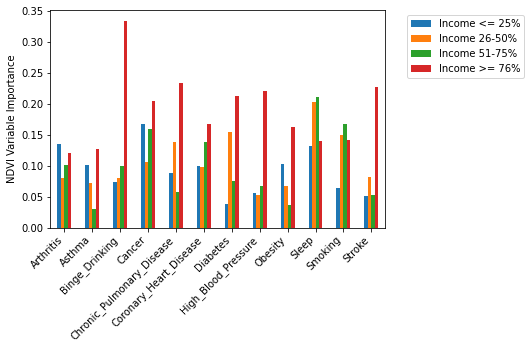

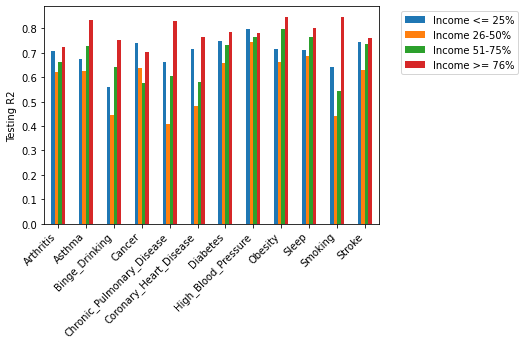

In [ ]:
n_im.plot.bar(x='Factor')
plt.ylabel('NDVI Variable Importance')
plt.xlabel('')
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


r2.plot.bar(x='Factor')
plt.ylabel('Testing R2')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")
plt.show()

Figure 9: These plots show the importance of NDVI in predicting health factors and the R2 of the random forest regression models for each health factor, broken down by four income levels. The first plot shows that the importance of NDVI is highest in the highest income level, even for health factors in which it was relatively low within other income levels. This is especially true with binge drinking which has a very high NDVI variable importance at an income level >= 75%.

The second plot shows that R2 is typically lowest in the income level 25-50% and highest in income >= 75%, indicating that the model performs better among the highest income earners.

**Breakdown of binge drinking by income level**


Because binge drinking showed such as change in NDVI importance between income levels, the data will further be broken down here.

In [ ]:
print('Income Level <= 25%')
print('')
print('Income max:', l1['income'].max())
print('Income min:',l1['income'].min())
print('Income mean:',l1['income'].mean())
print('')
print('Binge drinking max:', l1['Binge_Drinking'].max())
print('Binge drinking min:',l1['Binge_Drinking'].min())
print('Binge drinking mean:',l1['Binge_Drinking'].mean())
print('_______________________________')
print('Income Level 26-50%')
print('')
print('Income max:', l2['income'].max())
print('Income min:',l2['income'].min())
print('Income mean:',l2['income'].mean())
print('')
print('Binge drinking max:', l2['Binge_Drinking'].max())
print('Binge drinking min:',l2['Binge_Drinking'].min())
print('Binge drinking mean:',l2['Binge_Drinking'].mean())
print('_______________________________')
print('Income Level 51-75%')
print('')
print('Income max:', l3['income'].max())
print('Income min:',l3['income'].min())
print('Income mean:',l3['income'].mean())
print('')
print('Binge drinking max:', l3['Binge_Drinking'].max())
print('Binge drinking min:',l3['Binge_Drinking'].min())
print('Binge drinking mean:',l3['Binge_Drinking'].mean())
print('_______________________________')
print('Income Level >= 76%')
print('')
print('Income max:', l4['Binge_Drinking'].max())
print('Income min:',l4['Binge_Drinking'].min())
print('Income mean:',l4['Binge_Drinking'].mean())
print('')
print('Binge drinking max:', l4['Binge_Drinking'].max())
print('Binge drinking min:',l4['Binge_Drinking'].min())
print('Binge drinking mean:',l4['Binge_Drinking'].mean())


Income Level <= 25%

Income max: 37459
Income min: 3558
Income mean: 29020.49246231156

Binge drinking max: 32.8
Binge drinking min: 6.1
Binge drinking mean: 15.673330940416376
_______________________________
Income Level 26-50%

Income max: 53721
Income min: 37461
Income mean: 45385.97026932494

Binge drinking max: 35.1
Binge drinking min: 7.0
Binge drinking mean: 17.697516614200765
_______________________________
Income Level 51-75%

Income max: 77885
Income min: 53397
Income mean: 64221.70872436566

Binge drinking max: 35.7
Binge drinking min: 7.3
Binge drinking mean: 18.622419186652735
_______________________________
Income Level >= 76%

Income max: 34.8
Income min: 4.5
Income mean: 19.796838539706368

Binge drinking max: 34.8
Binge drinking min: 4.5
Binge drinking mean: 19.796838539706368


Table 9: Maximum, minimum, and average income and percentage of binge drinkers in each income level. As income level increases, the average percentage of binge drinkers also increases.

In [ ]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='Binge_Drinking ~ age', data=dat2)
res = mod.fit()

In [ ]:
# calculate Pearson's correlation
corr, _ = pearsonr(dat2.age, dat2.Binge_Drinking)
print('Pearsons correlation (Age and Binge Drinking) for whole dataset: %.3f' % corr)

corr, _ = pearsonr(l1.age, l1.Binge_Drinking)
print('Pearsons correlation (Age and Binge Drinking) for Income <= 25 percent: %.3f' % corr)

corr, _ = pearsonr(l2.age, l2.Binge_Drinking)
print('Pearsons correlation (Age and Binge Drinking) for Income 26-50 percent: %.3f' % corr)

corr, _ = pearsonr(l3.age, l3.Binge_Drinking)
print('Pearsons correlation (Age and Binge Drinking) for Income 51-75 percent: %.3f' % corr)

corr, _ = pearsonr(l4.age, l4.Binge_Drinking)
print('Pearsons correlation (Age and Binge Drinking) for Income >= 76 percent: %.3f' % corr)

Pearsons correlation (Age and Binge Drinking) for whole dataset: -0.123
Pearsons correlation (Age and Binge Drinking) for Income <= 25 percent: -0.321
Pearsons correlation (Age and Binge Drinking) for Income 26-50 percent: -0.327
Pearsons correlation (Age and Binge Drinking) for Income 51-75 percent: -0.296
Pearsons correlation (Age and Binge Drinking) for Income >= 76 percent: -0.466


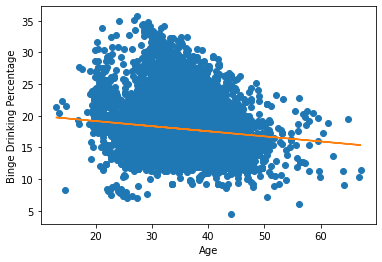

In [ ]:
plt.plot(dat2['age'], dat2['Binge_Drinking'], 'o')
plt.plot(dat2.age, res.predict(dat2))
plt.title('')
plt.xlabel('Age')
plt.ylabel('Binge Drinking Percentage');

Figure 10: Scatterplot of the entire dataset for age and binge drinking. The trend shows that younger people tend to have a higher percentage of binge drinking.

In [ ]:
mod = smf.ols(formula='Binge_Drinking ~ ndvi', data=dat2)
res = mod.fit()


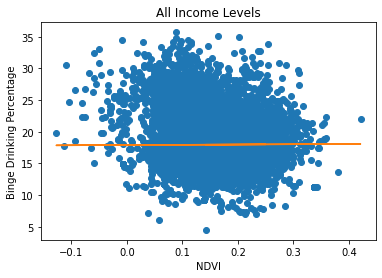

In [ ]:
plt.plot(dat2['ndvi'], dat2['Binge_Drinking'], 'o')
plt.plot(dat2.ndvi, res.predict(dat2))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Binge Drinking Percentage')
plt.title('All Income Levels');

Figure 11: Scatterplot between NDVI and binge drinking in the entire dataset. The trend is not significant when looking at all income levels.

In [ ]:
mod1 = smf.ols(formula='Binge_Drinking ~ ndvi', data=l1)
res1 = mod1.fit()

mod2 = smf.ols(formula='Binge_Drinking ~ ndvi', data=l2)
res2 = mod2.fit()

mod3 = smf.ols(formula='Binge_Drinking ~ ndvi', data=l3)
res3 = mod3.fit()

mod4 = smf.ols(formula='Binge_Drinking ~ ndvi', data=l4)
res4 = mod4.fit()


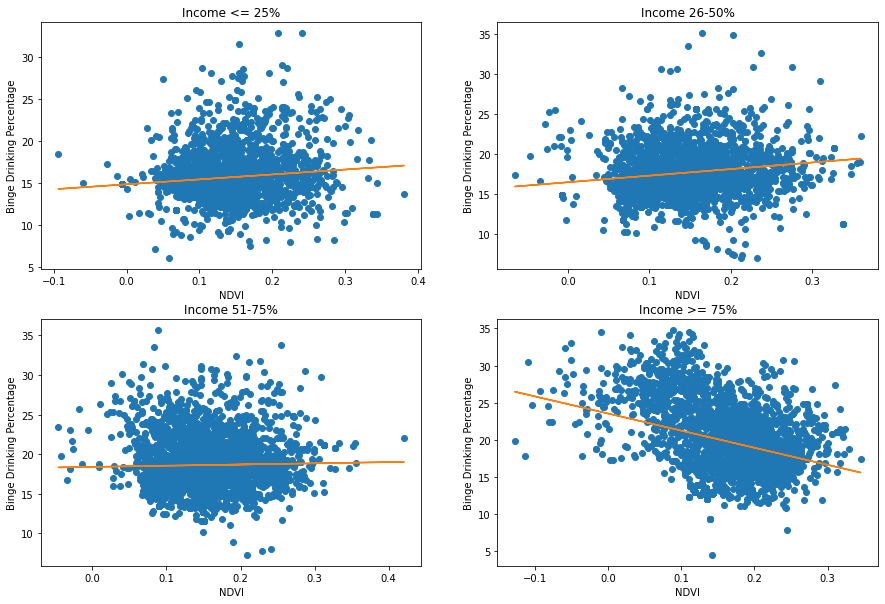

In [ ]:
fig = plt.figure(figsize = [15,10])

plt.subplot(2, 2, 1)

plt.plot(l1['ndvi'], l1['Binge_Drinking'], 'o')
plt.plot(l1.ndvi, res1.predict(l1))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Binge Drinking Percentage')
plt.title('Income <= 25%');

plt.subplot(2, 2, 2)

plt.plot(l2['ndvi'], l2['Binge_Drinking'], 'o')
plt.plot(l2.ndvi, res2.predict(l2))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Binge Drinking Percentage')
plt.title('Income 26-50%');

plt.subplot(2, 2, 3)

plt.plot(l3['ndvi'], l3['Binge_Drinking'], 'o')
plt.plot(l3.ndvi, res3.predict(l3))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Binge Drinking Percentage')
plt.title('Income 51-75%');


plt.subplot(2, 2, 4)

plt.plot(l4['ndvi'], l4['Binge_Drinking'], 'o')
plt.plot(l4.ndvi, res4.predict(l4))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Binge Drinking Percentage')
plt.title('Income >= 75%');

plt.show()

Figure 12: Scatterplots of binge drinking and NDVI across four income levels. The trend between low NDVI and high binge drinking is much more significant in income >= 76%. This indicates that there is a correlation between higher NDVI and lower binge drinking rates.

In [ ]:
mod1 = smf.ols(formula='Smoking ~ ndvi', data=l1)
res1 = mod1.fit()

mod2 = smf.ols(formula='Smoking ~ ndvi', data=l2)
res2 = mod2.fit()

mod3 = smf.ols(formula='Smoking ~ ndvi', data=l3)
res3 = mod3.fit()

mod4 = smf.ols(formula='Smoking ~ ndvi', data=l4)
res4 = mod4.fit()

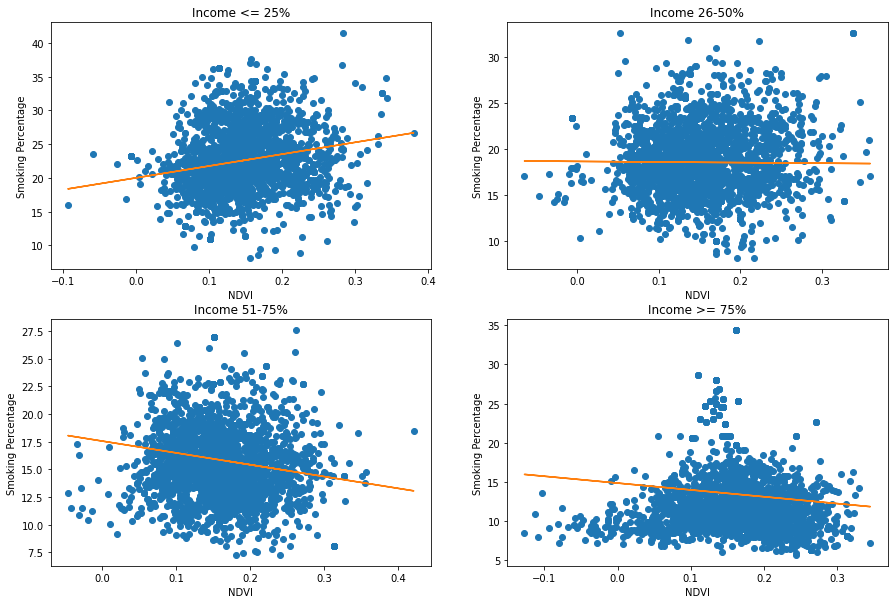

In [ ]:
fig = plt.figure(figsize = [15,10])

plt.subplot(2, 2, 1)

plt.plot(l1['ndvi'], l1['Smoking'], 'o')
plt.plot(l1.ndvi, res1.predict(l1))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Smoking Percentage')
plt.title('Income <= 25%');

plt.subplot(2, 2, 2)

plt.plot(l2['ndvi'], l2['Smoking'], 'o')
plt.plot(l2.ndvi, res2.predict(l2))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Smoking Percentage')
plt.title('Income 26-50%');

plt.subplot(2, 2, 3)

plt.plot(l3['ndvi'], l3['Smoking'], 'o')
plt.plot(l3.ndvi, res3.predict(l3))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Smoking Percentage')
plt.title('Income 51-75%');


plt.subplot(2, 2, 4)

plt.plot(l4['ndvi'], l4['Smoking'], 'o')
plt.plot(l4.ndvi, res4.predict(l4))
plt.title('')
plt.xlabel('NDVI')
plt.ylabel('Smoking Percentage')
plt.title('Income >= 75%');

plt.show()

Figure 13: Scatterplots of percentage of population that smokes and NDVI across four income levels. Because of the trend in binge drinking, I wanted to see the trend in smoking, as this is another substance that can be abused. The same trend does not hold up here, however the scatterplot in the highest income level still looks very different when compared to the other income levels. This indicates there may be a difference in how higher income urban areas interact with green space and the effect it has on substance abuse.